# Flavors of Gradient Descent

Gradient descent (GD) is a tremendously popular optimization algorithm in the machine learning world. While it's been popular for a long time, there have been a number of variations on plain-vanilla SGD that have improved training speed and stability. The four we'll cover in this post are:
* Basic gradient descent
* Momentum
* RMSProp
* Adam

First, a brief review. GD's purpose is simple: given a function, change the parameters of that function to find its minimum. One of the major "families" of (supervised) machine learning models is the set of *parametric* models, or those which work by tuning a set of _parameters_ (hence the name!) to optimize some objective criterion. In each case, we have a function that takes a series of samples, and for each, tries to predict a target; that is:

$$
\operatorname*{argmin}_fL(y,f(x))
$$

Where $f$ is a parametric supervised learning model, $y$ is a vector of ground-truth values, $x$ is a feature matrix $\in R^{mn}$ and $f$ is a function $R^{m*n} \Rightarrow R^{1*n}$; for simplicity, let's assume it's a basic linear regression, such as $f(x) = \beta_{0} + \beta_{1}x$. In this case, we want to find the parameters $\beta_0$ and $\beta_1$ that minimize the average _loss_ (function $l$ above) given a set of examples $y$ and a set of inputs $x$. For example's sake, let's assume that loss to be _Mean Squared Error (MSE)_: $\frac{1}{n}\sum^n_1(y_i - f(x_i))^2$. Gradient descent helps us find the parameters $\beta_0$ and $\beta_1$ that make the MSE as small as possible.

How is this done? The broad idea is straightforward: figure out how the loss moves in relation to each parmeter, and use that information to determine whether to increase or decrease the parameter. Repeat the process many times, until the loss won't go any lower. Each "flavor" of GD outlined above does this in some form, but the nuances of the approach differ. 

Let's start by generating a bit of data on which we can run our GS algorithm to examine training performance.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from numpy.random import normal
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

In [3]:
import torch

# Generate Some Data

First, let's pick some constants to be our "true" $\beta_0$ and $\beta_1$. Remember: our goal is to take some data generated by a linear model with these parameters, and use it to back into what the parameters were algorithmically. We'll set $\beta_1 = 30$ and $\beta_0 = 15$.

In [4]:
b1, b0 = 30, 15

Next, we want to generated some input and output data. This will be our synthetic training data, which we'll use to back into the parameters we set above. Our data will be centered around the line $y = 30x + 15$, with a small amount of normally distributed noise added, with a mean of 0 and standard deviation of 1.

In [24]:
x_train = np.linspace(0, 100, 100)

In [25]:
y_train = b1 * x_train + b0 + normal(size=len(x_train))

Here, we've used scipy's `normal` function to generate random error terms with mean 0 and standard deviation 1.

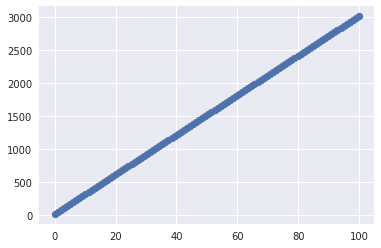

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x_train, y_train)

The data clings pretty tightly to our ground-truth function, which is fine for now -- real-world data is almost never so clean, but it'll work for the purposes of this post.

# Basic SGD

The first variant we're going to work through is basic SGD. The idea in basic SGD is simple: we find the gradient of the error with respect to the inputs, and then we subtract that gradient (multipled by a small number) to improve the error a bit. More formally:

$$ a_{t+1} = a_t - \alpha\frac{\delta{L}}{\delta{a}}$$

where $\alpha$ is the learning rate, and $\frac{\delta{L}}{\delta{a}}$ is the gradient of the loss with respect to the parameter $a$. Basic SGD does exactly this, more-or-less, with no modifications. One thing worth noting is that the process changes based on _how many_ examples you use to determine the gradient. Broadly, there are three ways to do this:
* Batch gradient descent, which computes the gradient over every example in the training set, and then makes one parameter update per epoch (i.e. for each complete pass through the data)
* Mini-batch gradient descent, which breaks the training set into chunks and computes the gradient (and performs parameter updates) for each chunk
* Online gradient descent, which computes the gradient and updates the parameters for each individual training example

There are advantages and disadvantages to each of these, primarily around training speed and stability. To scope this post down to a reasonable level, I'll save that discussion for a different post. For the purposes of this post, we're going to be using batch gradient descent for each variant of SGD.

In [35]:
# set the epoch count to 50000
epochs = 50000

# initialize our parameters
b0_hat, b1_hat = 0, 0

# set the learning rate
lr = 1e-4

# we'll use this list to collect our losses for reporting
basic_losses = []

# This is our main optimization loop. For each epoch, we're going to
# compute the average gradient over the entire dataset, then use that
# average gradient to update the parameters. 
for i in range(epochs):
    
    # vectorized prediction for the  basic linear model
    predictions = np.dot(b1_hat, x_train) + b0_hat
    
    # compute the loss for each example
    loss = (predictions - y_train)**2
    
    # log the MSE for the epoch
    basic_losses.append(loss.mean())
    
    # compute the gradients for each parameter
    grad_b0 = (2 * (predictions - y_train)).mean()
    grad_b1 = (2 * (predictions - y_train) * x_train).mean()
    
    # update the parameters
    b0_hat = b0_hat - grad_b0 * lr
    b1_hat = b1_hat - grad_b1 * lr
    
    # every 10k epochs, print out the loss
    if (i % 10000 == 0):
        print("Epoch %s MSE: %s" % (i, basic_losses[-1]))
        print("b0_hat is %s" % b0_hat)
        print("b1_hat is %s" % b1_hat)
print("Best loss: ", min(basic_losses))

Epoch 0 MSE: 3060533.696181104
b0_hat is 0.30300950520015735
b1_hat is 20.251526299769125
Epoch 10000 MSE: 20.45762293523531
b0_hat is 6.255557333936195
b1_hat is 30.131287842694327
Epoch 20000 MSE: 7.984352926739002
b0_hat is 9.749650815607396
b1_hat is 30.079135864817022
Epoch 30000 MSE: 3.4634447455217763
b0_hat is 11.853221944350848
b1_hat is 30.047738480761605
Epoch 40000 MSE: 1.8248519170916848
b0_hat is 13.119648133831623
b1_hat is 30.02883611568079
Best loss:  1.2309819621626716


By the end of our training loop, you can see that the learned parameters, $\hat{\beta}_{0} = 13.12$ and $\hat{\beta}_{1} = 30.02$ are pretty close to our true parameters $\beta_{0} = 15$ and $\beta_{1} = 30$, so our algorithm is working as we expect.

## SGD Basic - PyTorch Version

For each variant, I also wanted to take the time to demonstrate what it would look like in PyTorch, one of the more popular deep learning platforms. We start by creating a PyTorch tensor. `torch.tensor` is a constructor for `torch.Tensor` objects, which work a lot like numpy tensors with extra functionality that allow them to be stored on a GPU. We also add a feature of ones to the dataset to account for $\beta_{0}$, which can then be optimized with the same gradient calculation as $\beta_1$ in our training loop.

In [36]:
_x_train_torch = np.concatenate((x_train[:,np.newaxis], np.ones((len(x_train)))[:,np.newaxis]), axis=1)
x_train_torch = torch.tensor(_x_train_torch).double()

In [37]:
x_train_torch.shape, w.shape

(torch.Size([100, 2]), torch.Size([2]))

In [38]:
x_train_torch[:5]

tensor([[0.0000, 1.0000],
        [1.0101, 1.0000],
        [2.0202, 1.0000],
        [3.0303, 1.0000],
        [4.0404, 1.0000]], dtype=torch.float64)

In [39]:
def mse(y_true, y_pred): return ((y_true - y_pred)**2).mean()

In [33]:
y_train_torch = torch.tensor(y_train)

In [34]:
w = torch.nn.Parameter(torch.tensor([0.,0.]).double())
lr = 1e-4
basic_losses_torch = []
for i in range(50000):
    pred = x_train_torch@w
    loss = mse(y_train_torch, pred)
    basic_losses_torch.append(loss.item())
    if i % 10000 == 0: print(np.sqrt(loss.detach().numpy()))
    loss.backward()
    with torch.no_grad():
        w.sub_(lr * w.grad)
        w.grad.zero_() 
print(np.sqrt(min(basic_losses_torch)))

1749.4381087026497
4.523010384161774
2.8256597330073205
1.8610332467534738
1.3508707995554885
1.1094962650512492


# Momentum

In [19]:
epochs = 50000
a_hat, b_hat = 0., 0.
lr = 1e-3
mom = 0.9
mom_losses = []
grad_a = 0.0
grad_b = 0.0
for i in range(epochs):
    prediction = np.dot(a_hat, x_train) + b_hat
    loss = np.mean((prediction - y_train)**2)
    mom_losses.append(loss)
    grad_a = np.mean(2 * (prediction - y_train) * x_train) * (1 - mom) + grad_a * mom
    grad_b = np.mean(2 * (prediction - y_train)) * (1 - mom) + grad_b * mom
    a_hat = a_hat - grad_a * lr
    b_hat = b_hat - grad_b * lr
    if (i % 10000 == 0):
        print("The most recent loss after epoch %s is %s" % (i, np.sqrt(loss)))
        print("a_hat is %s" % a_hat)
        print("b_hat is %s" % b_hat)
print("Best loss: ", min(mom_losses))

The most recent loss after epoch 0 is 1775.3399029003915
a_hat is 20.42608101348564
b_hat is 0.3061450025880595
The most recent loss after epoch 10000 is 195.46258656134677
a_hat is 30.10709685012657
b_hat is 25.331253310966208
The most recent loss after epoch 20000 is 195.46257127267637
a_hat is 30.10482135073294
b_hat is 25.483707885508505
The most recent loss after epoch 30000 is 195.4625712721069
a_hat is 30.104807462954312
b_hat is 25.484638342967305
The most recent loss after epoch 40000 is 195.46257127210689
a_hat is 30.104807378194717
b_hat is 25.484644021715106
Best loss:  38205.616768303444


In [20]:
def loss_list(losses):
    return list(map(lambda x: np.mean(x), losses))

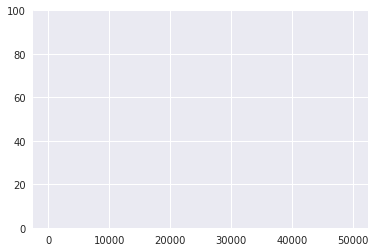

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111)
# momentum_losses = losses
# ax.set_xlim(0,3000)
ax.set_ylim(0,100)
plt.plot(loss_list(mom_losses), color="blue")
plt.plot(loss_list(basic_losses), color="red")
# plot_losses(losses[1:], 1000)

We see that the model can handle a learning rate 10x larger, allowing us to learn much more quickly. The SGD-based version could not handle the larger learning rate, and immediately started to diverge. 

## Momentum - PyTorch Version

In [25]:
w = torch.nn.Parameter(torch.tensor([0.,0.]).double())
lr = 1e-3
mom = 0.9
grad = torch.tensor([0.,0.]).double()
mom_torch_losses = []
for i in range(50000):
    pred = x_train_torch@w
    loss = mse(y_train_torch, pred).double()
    mom_torch_losses.append(loss)
    if i % 10000 == 0: print(loss)
    loss.backward()
    with torch.no_grad():
        grad_mom = mom * grad + (1 - mom) * w.grad
        w.sub_(lr * grad_mom)
        grad = grad_mom
        w.grad.zero_() 

tensor(3060265.0966, dtype=torch.float64, grad_fn=<MeanBackward1>)
tensor(0.9793, dtype=torch.float64, grad_fn=<MeanBackward1>)
tensor(0.9772, dtype=torch.float64, grad_fn=<MeanBackward1>)
tensor(0.9772, dtype=torch.float64, grad_fn=<MeanBackward1>)
tensor(0.9772, dtype=torch.float64, grad_fn=<MeanBackward1>)


# RMSProp

In [27]:
epochs = 50000
a_hat, b_hat = 0, 0
lr = 1e-2
beta = 0.9
rms_losses = []
r_a = 0
r_b = 0
grad_a = 0
grad_b = 0
eta = 1e-10
for i in range(1, epochs + 1):
    predictions = a_hat * x_train + b_hat
    loss = ((predictions - y_train)**2).mean()
    rms_losses.append(loss)
     
    grad_a = (2 * (predictions - y_train) * x_train).mean()
    grad_b = (2 * (predictions - y_train)).mean()
     
    r_a = (beta*r_a + (1 - beta)*grad_a**2) / (1 - beta**i)
    r_b = (beta*r_b + (1 - beta)*grad_b**2) / (1 - beta**i)
     
    v_a = grad_a*np.divide(lr, np.sqrt(r_a) + eta)
    v_b = grad_b*np.divide(lr, np.sqrt(r_b) + eta)
    
    a_hat = a_hat - v_a
    b_hat = b_hat - v_b
    
    if (i % 5000 == 0):
        print("The most recent after epoch %s is %s" % (i, rms_losses[-1]))
        print("a_hat is %s" % a_hat)
        print("b_hat is %s" % b_hat)
print("Best loss: ", min(rms_losses))

The most recent after epoch 5000 is 1.0635296202610103
a_hat is 30.00158555385953
b_hat is 15.196067246693122
The most recent after epoch 10000 is 1.0634643388384801
a_hat is 30.001824516445303
b_hat is 15.180136282584968
The most recent after epoch 15000 is 1.0634643388384801
a_hat is 30.001824516445303
b_hat is 15.180136282584968
The most recent after epoch 20000 is 1.0634643388384801
a_hat is 30.001824516445303
b_hat is 15.180136282584968
The most recent after epoch 25000 is 1.0634643388384801
a_hat is 30.001824516445303
b_hat is 15.180136282584968
The most recent after epoch 30000 is 1.0634643388384801
a_hat is 30.001824516445303
b_hat is 15.180136282584968
The most recent after epoch 35000 is 1.0634643388384801
a_hat is 30.001824516445303
b_hat is 15.180136282584968
The most recent after epoch 40000 is 1.0634643388384801
a_hat is 30.001824516445303
b_hat is 15.180136282584968
The most recent after epoch 45000 is 1.0634643388384801
a_hat is 30.001824516445303
b_hat is 15.1801362825

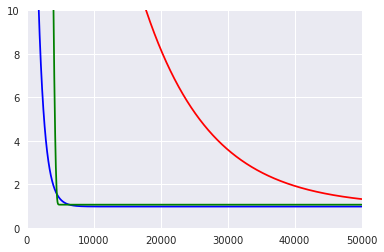

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111)
# momentum_losses = losses
ax.set_xlim(0,50000)
ax.set_ylim(0,10)
plt.plot(loss_list(mom_losses), color="blue")
plt.plot(loss_list(basic_losses), color="red")
plt.plot(loss_list(rms_losses), color="green")

# RMSProp - PyTorch Version

In [29]:
w = torch.nn.Parameter(torch.tensor([0.,0.]).double())
epochs = 50000
lr = 1e-2
beta = 0.9
exp_moving_avg = torch.tensor([0.,0.]).double()
eta = 1e-10
for i in range(1, epochs + 1):
    pred = x_train_torch@w
    loss = mse(y_train_torch, pred).double()
    if i % 5000 == 0: 
        print(loss)
    loss.backward()
    with torch.no_grad():
        exp_moving_avg = (beta * exp_moving_avg + (1 - beta)*w.grad**2) / (1 - beta**i)
        w.sub_(w.grad * lr / (np.sqrt(exp_moving_avg) + eta))
        w.grad.zero_() 

tensor(1.0635, dtype=torch.float64, grad_fn=<MeanBackward1>)
tensor(1.0635, dtype=torch.float64, grad_fn=<MeanBackward1>)
tensor(1.0635, dtype=torch.float64, grad_fn=<MeanBackward1>)
tensor(1.0635, dtype=torch.float64, grad_fn=<MeanBackward1>)
tensor(1.0635, dtype=torch.float64, grad_fn=<MeanBackward1>)
tensor(1.0635, dtype=torch.float64, grad_fn=<MeanBackward1>)
tensor(1.0635, dtype=torch.float64, grad_fn=<MeanBackward1>)
tensor(1.0635, dtype=torch.float64, grad_fn=<MeanBackward1>)
tensor(1.0635, dtype=torch.float64, grad_fn=<MeanBackward1>)
tensor(1.0635, dtype=torch.float64, grad_fn=<MeanBackward1>)


# Adam

In [30]:
epochs = 50000
a_hat, b_hat = 0, 0
lr = 1e-2

beta1 = 0.9
beta2 = 0.9

adam_losses = []

r_a = 0
r_b = 0
grad_a = 0
grad_b = 0
mom_a = 0
mom_b = 0
eta = 10e-1

for i in range(1, epochs + 1):
    predictions = a_hat * x_train + b_hat
    loss = ((predictions - y_train)**2).mean()
    adam_losses.append(loss)
    
    grad_b = (2 * (predictions - y_train)).mean()
    grad_a = (2 * (predictions - y_train) * x_train).mean()
     
    r_a = (beta2*r_a + (1 - beta2)*grad_a**2) / (1 - beta2**i)
    r_b = (beta2*r_b + (1 - beta2)*grad_b**2) / (1 - beta2**i)
    
    mom_a = (grad_a * (1 - beta1) + mom_a * beta1) / (1 - beta1**i)
    mom_b = (grad_b * (1 - beta1) + mom_b * beta1) / (1 - beta1**i)

    v_a = mom_a * lr / (np.sqrt(r_a) + eta)
    v_b = mom_b * lr / (np.sqrt(r_b) + eta)      
    
    a_hat = a_hat - v_a
    b_hat = b_hat - v_b
         
    if (i % 10000 == 0):
        print("The most recent after epoch %s is %s" % (i, adam_losses[-1]))
        print("a_hat is %s" % a_hat)
        print("b_hat is %s" % b_hat)
print("Best loss: ", min(adam_losses))

The most recent after epoch 10000 is 0.9772035034843654
a_hat is 29.996685149488872
b_hat is 15.17513254882717
The most recent after epoch 20000 is 0.9771942517974239
a_hat is 29.996947875558817
b_hat is 15.175139586707182
The most recent after epoch 30000 is 0.9771879445709775
a_hat is 29.996718956963324
b_hat is 15.17513344936517
The most recent after epoch 40000 is 0.9771852044566064
a_hat is 29.996910610349904
b_hat is 15.175138603995327
The most recent after epoch 50000 is 0.9771865094312757
a_hat is 29.996759442604894
b_hat is 15.175134514468935
Best loss:  0.9771851300854203


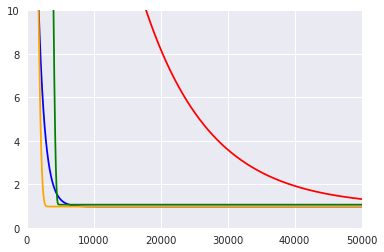

In [31]:
fig = plt.figure()
ax = fig.add_subplot(111)
# momentum_losses = losses
ax.set_xlim(0,50000)
ax.set_ylim(0,10)
plt.plot(loss_list(mom_losses), color="blue")
plt.plot(loss_list(basic_losses), color="red")
plt.plot(loss_list(rms_losses), color="green")
plt.plot(loss_list(adam_losses), color="orange")

# Adam - PyTorch Version

In [35]:
w = torch.nn.Parameter(torch.tensor([0.,0.]).double())
lr = 1e-2
beta1 = 0.9
beta2 = 0.9
grad = torch.tensor([0.,0.]).double()
mom_torch_losses = []
eta = 10e-1
moving_avg = 0
exp_moving_avg = 0
for i in range(50000):
    pred = x_train_torch@w
    loss = mse(y_train_torch, pred).double()
    mom_torch_losses.append(loss)
    if i % 10000 == 0: print(loss)
    loss.backward()
    with torch.no_grad():
        moving_avg = (beta1 * moving_avg + (1 - beta1) * w.grad) / (1 - beta1**(i+1))
        exp_moving_avg = (beta2 * exp_moving_avg + (1 - beta2) * w.grad**2) / (1 - beta2**(i+1))
        w.sub_(moving_avg * lr / (np.sqrt(exp_moving_avg) + eta))
        w.grad.zero_() 

tensor(3060265.0966, dtype=torch.float64, grad_fn=<MeanBackward1>)
tensor(0.9773, dtype=torch.float64, grad_fn=<MeanBackward1>)
tensor(0.9772, dtype=torch.float64, grad_fn=<MeanBackward1>)
tensor(0.9772, dtype=torch.float64, grad_fn=<MeanBackward1>)
tensor(0.9772, dtype=torch.float64, grad_fn=<MeanBackward1>)
